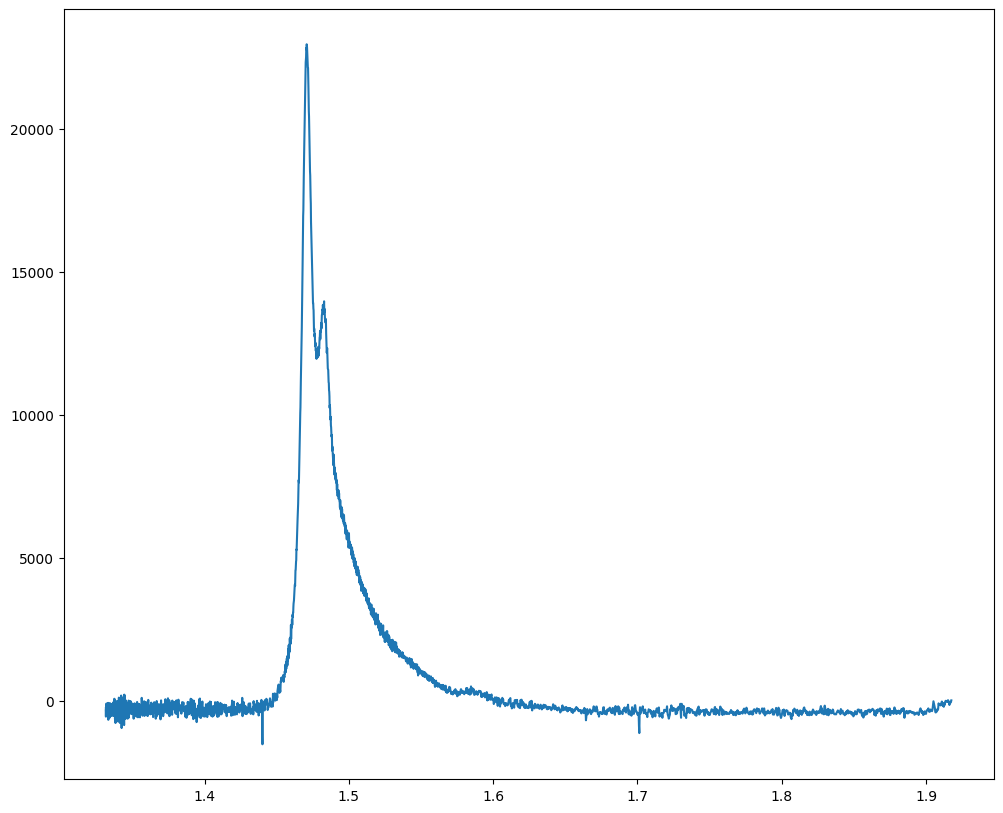

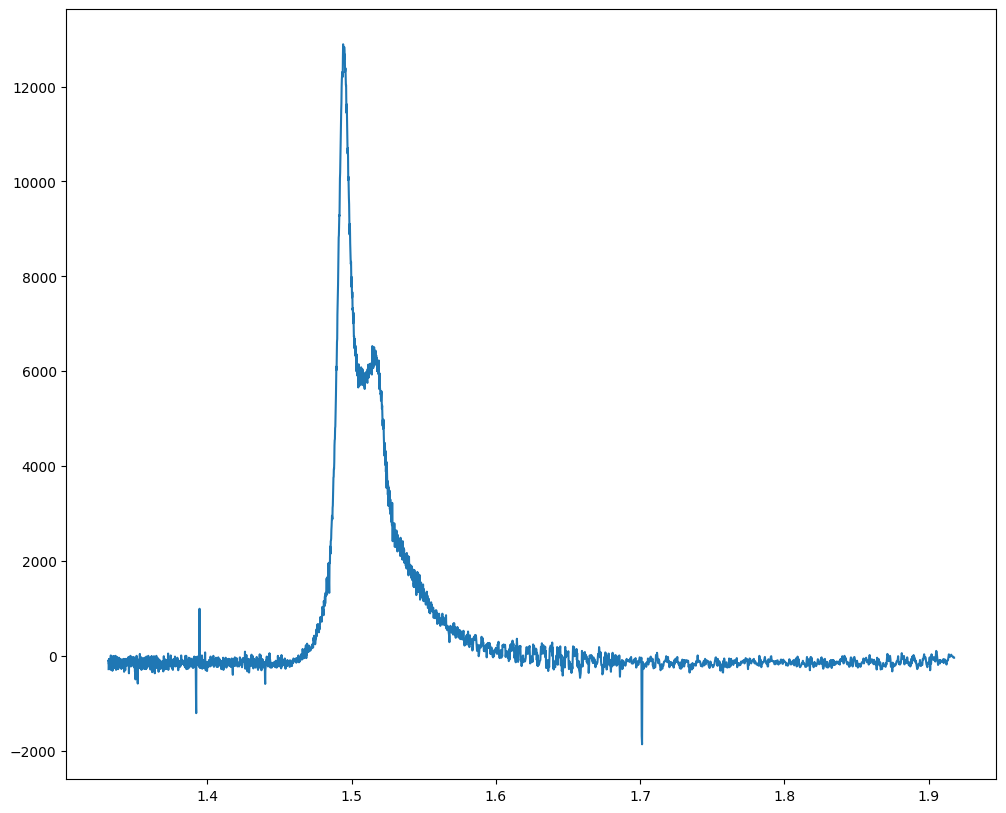

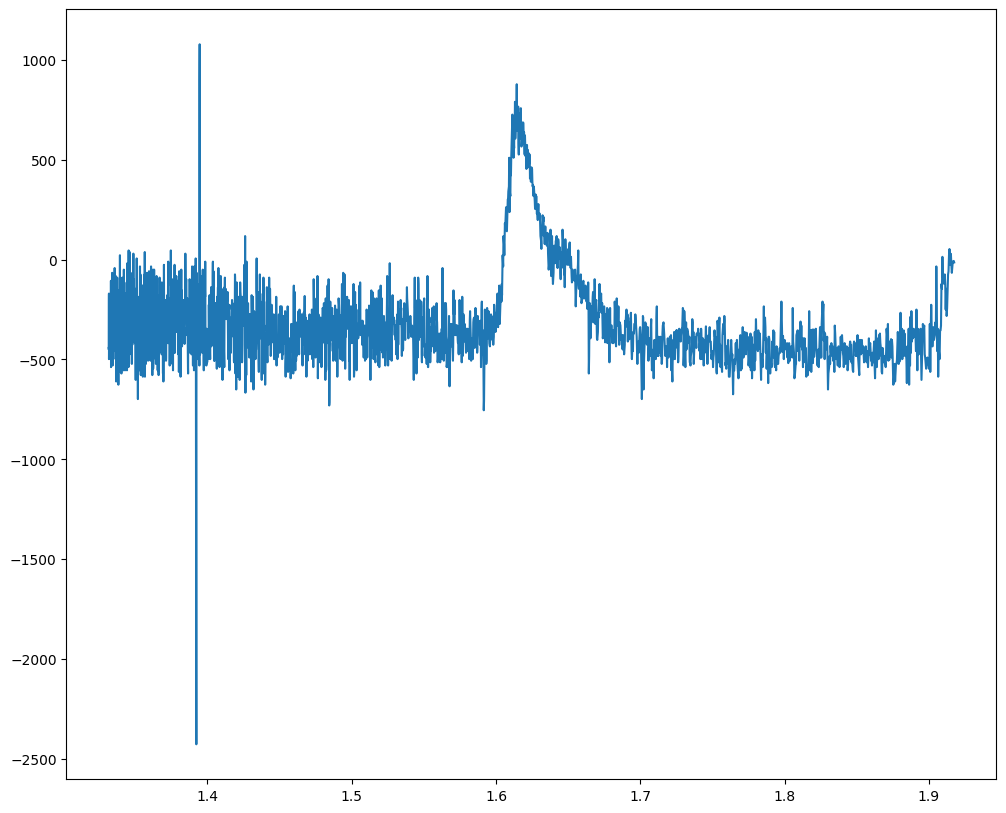

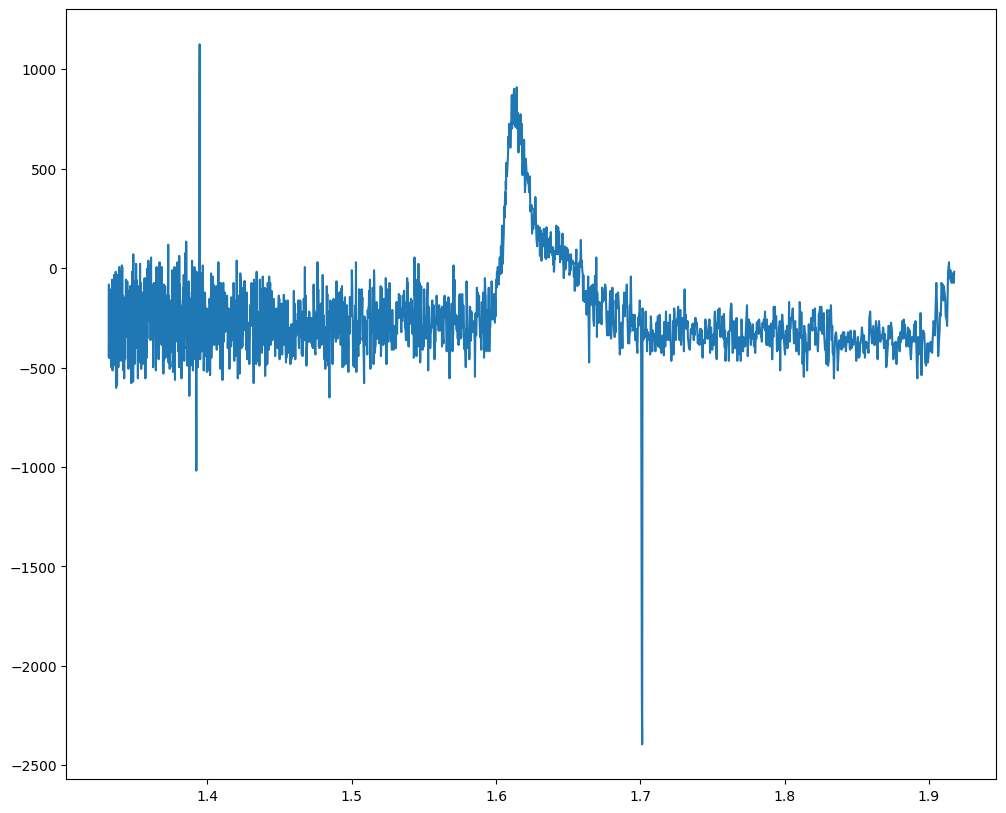

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.constants as ct


samples_names = ['a581','c262','c263','no_name']
intervals_list = [[810,870],[800,840],[730,790],[730,790]]
data = pd.DataFrame()
for sample_name in samples_names:
    parsed_data = pd.read_csv(f'./data_for_python/{sample_name}.csv', sep=' ')[1:]
    parsed_data.columns = ["lambda", f"I_{sample_name}"]
    data["lambda"] = parsed_data['lambda']
    data[f"I_{sample_name}"] = parsed_data[f"I_{sample_name}"]

data["omega"] = 2*np.pi *ct.c /data["lambda"]*10**9
data["ev"] = data["omega"] * ct.hbar / ct.e
for sample_name in samples_names: 
    plt.figure(figsize=(12,10))
    plt.plot(data['ev'],data[f"I_{sample_name}"])